In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed_W1.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed_W1.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

# drop uncorrelated features
#weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [3]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

In [4]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-06-20'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

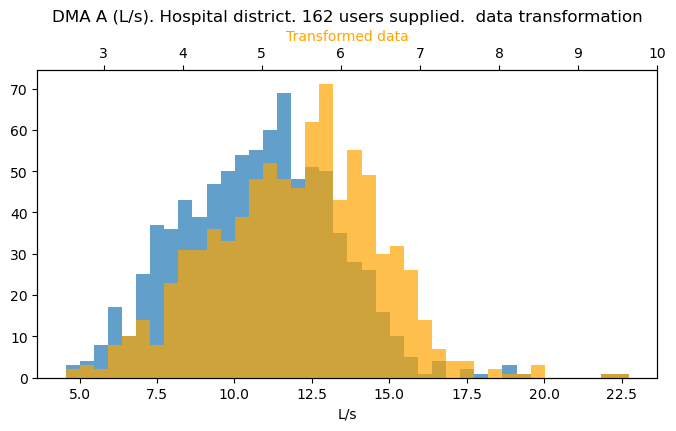

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12435D+00    |proj g|=  3.71973D-01


 This problem is unconstrained.



At iterate    5    f=  1.07116D+00    |proj g|=  2.86515D-01

At iterate   10    f=  1.04663D+00    |proj g|=  9.69011D-02

At iterate   15    f=  1.00044D+00    |proj g|=  2.97765D-01

At iterate   20    f=  9.94416D-01    |proj g|=  1.81241D-01

At iterate   25    f=  9.89653D-01    |proj g|=  7.11028D-02

At iterate   30    f=  9.88178D-01    |proj g|=  3.47271D-02

At iterate   35    f=  9.85872D-01    |proj g|=  5.09485D-02

At iterate   40    f=  9.83947D-01    |proj g|=  4.44202D-02

At iterate   45    f=  9.82948D-01    |proj g|=  7.30847D-02

At iterate   50    f=  9.80547D-01    |proj g|=  5.90601D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

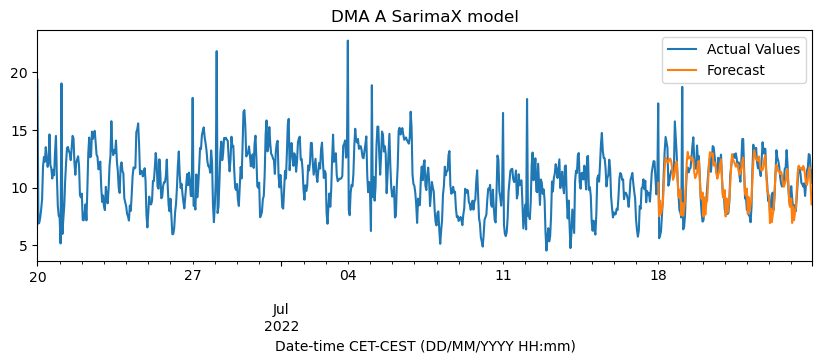

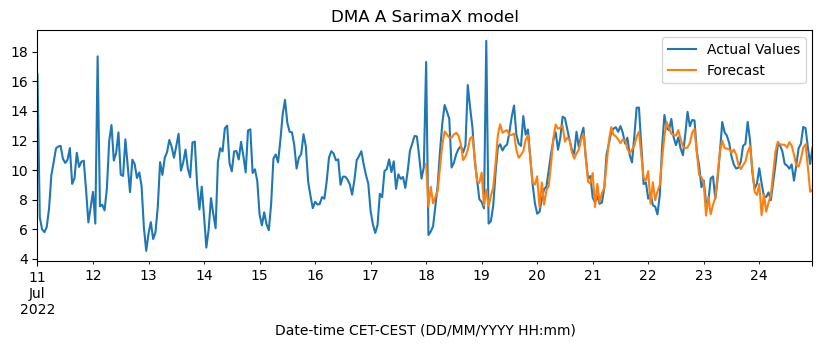

Performance indicators
DMA A SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.57            6.89             0.90           9.36 

Performance indicators


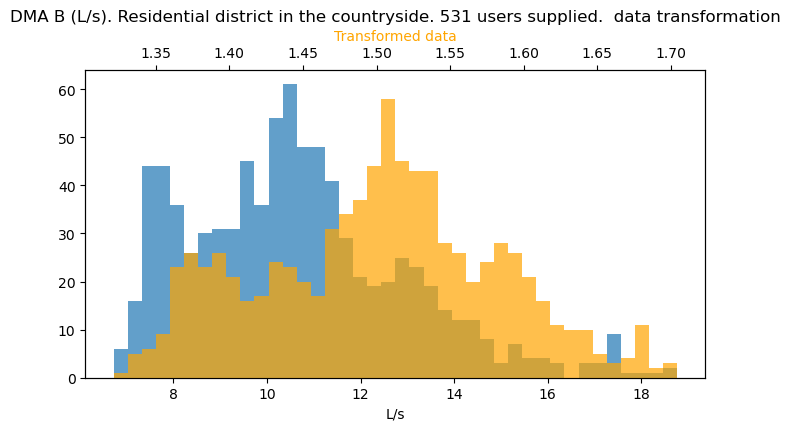

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27877D+00    |proj g|=  1.27460D+01


 This problem is unconstrained.



At iterate    5    f= -2.31884D+00    |proj g|=  6.42057D-01

At iterate   10    f= -2.32122D+00    |proj g|=  6.68291D+00

At iterate   15    f= -2.32560D+00    |proj g|=  1.35302D+00

At iterate   20    f= -2.32728D+00    |proj g|=  3.06306D+00

At iterate   25    f= -2.32877D+00    |proj g|=  1.47202D+00

At iterate   30    f= -2.33072D+00    |proj g|=  2.38189D+00

At iterate   35    f= -2.33083D+00    |proj g|=  3.65125D-01

At iterate   40    f= -2.33127D+00    |proj g|=  1.58405D+00

At iterate   45    f= -2.33809D+00    |proj g|=  9.10202D+00

At iterate   50    f= -2.34455D+00    |proj g|=  1.09813D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

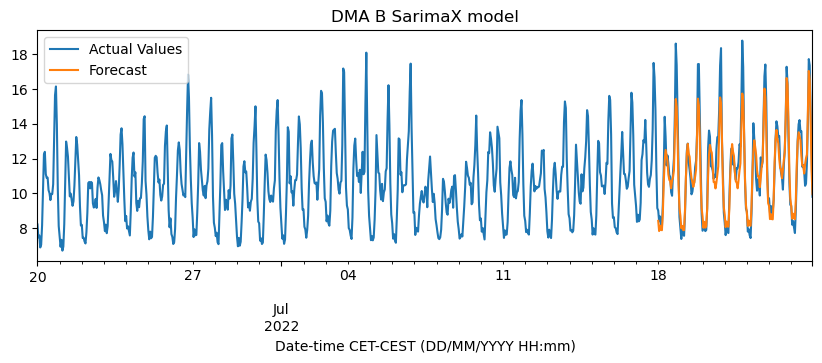

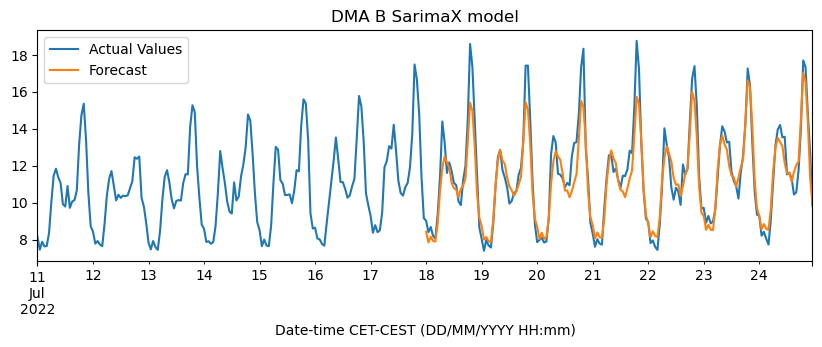

Performance indicators
DMA B SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.86            3.18             0.64           4.67 

Performance indicators


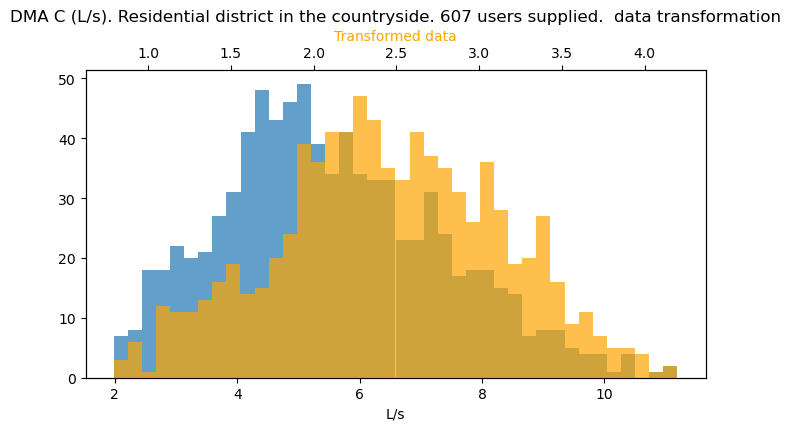

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59217D-01    |proj g|=  1.31114D+00


 This problem is unconstrained.



At iterate    5    f= -1.93315D-01    |proj g|=  7.54091D-02

At iterate   10    f= -1.97679D-01    |proj g|=  7.62284D-02

At iterate   15    f= -2.05298D-01    |proj g|=  3.06332D-01

At iterate   20    f= -2.06825D-01    |proj g|=  5.96568D-01

At iterate   25    f= -2.11565D-01    |proj g|=  1.89571D-01

At iterate   30    f= -2.15579D-01    |proj g|=  7.59713D-01

At iterate   35    f= -2.16416D-01    |proj g|=  1.68756D-01

At iterate   40    f= -2.18320D-01    |proj g|=  4.78525D-01

At iterate   45    f= -2.22179D-01    |proj g|=  1.13793D-01

At iterate   50    f= -2.24012D-01    |proj g|=  2.78519D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

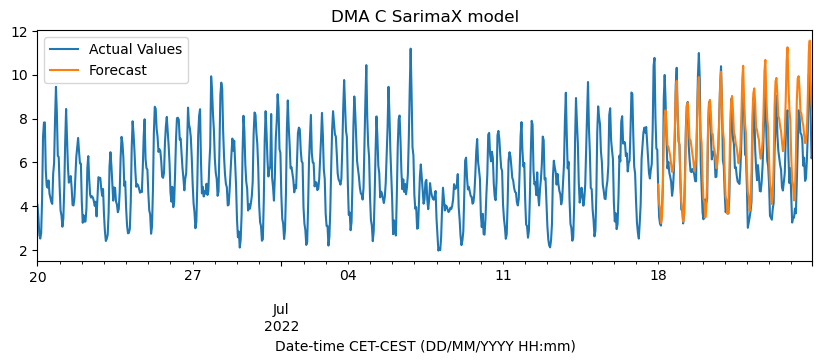

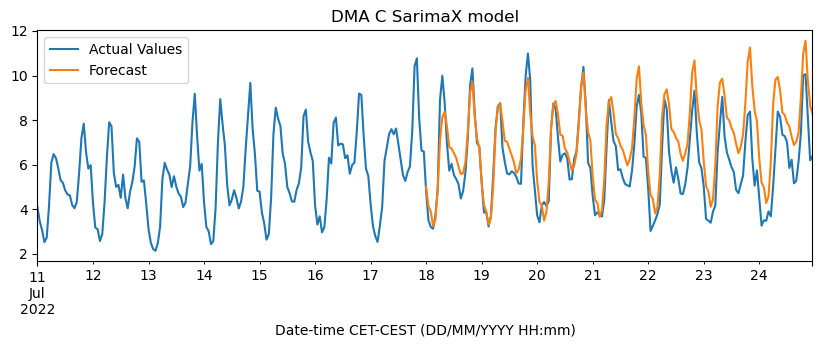

Performance indicators
DMA C SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.63            1.86             1.16           3.65 

Performance indicators


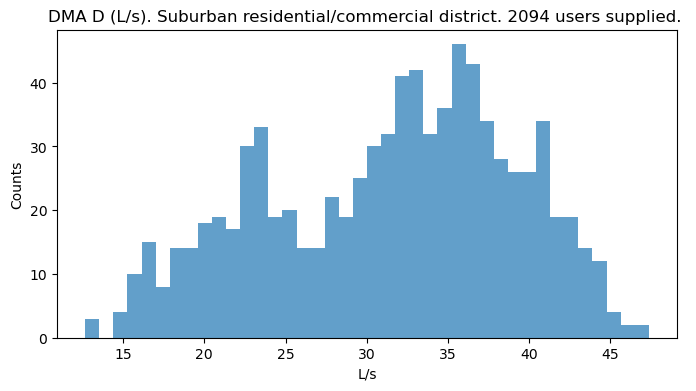

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45802D+00    |proj g|=  1.16221D-01


 This problem is unconstrained.



At iterate    5    f=  2.37092D+00    |proj g|=  1.18921D-01

At iterate   10    f=  2.35689D+00    |proj g|=  7.00488D-02

At iterate   15    f=  2.34967D+00    |proj g|=  3.26496D-02

At iterate   20    f=  2.34635D+00    |proj g|=  1.57132D-02

At iterate   25    f=  2.34268D+00    |proj g|=  2.52633D-02

At iterate   30    f=  2.33976D+00    |proj g|=  2.86030D-02

At iterate   35    f=  2.33876D+00    |proj g|=  3.89526D-03

At iterate   40    f=  2.33847D+00    |proj g|=  9.97492D-03

At iterate   45    f=  2.33818D+00    |proj g|=  1.53420D-02

At iterate   50    f=  2.33718D+00    |proj g|=  3.15411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

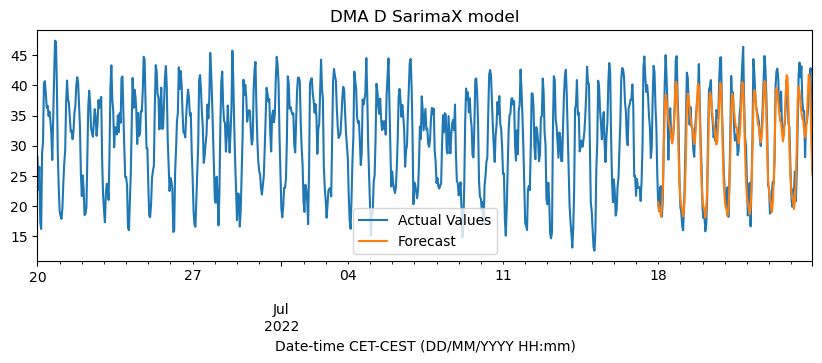

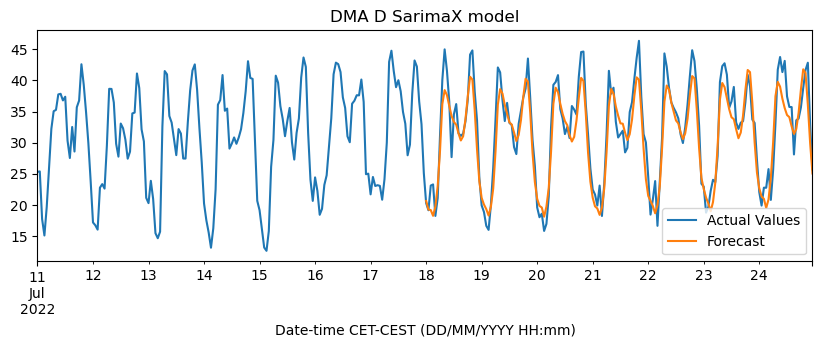

Performance indicators
DMA D SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.49            6.60             2.40           11.49 



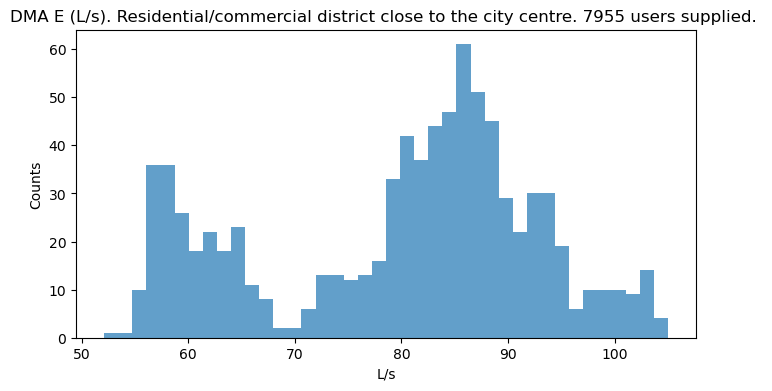

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47842D+00    |proj g|=  5.22890D-01


 This problem is unconstrained.



At iterate    5    f=  2.25784D+00    |proj g|=  7.04334D-02

At iterate   10    f=  2.18090D+00    |proj g|=  2.44607D-02

At iterate   15    f=  2.17072D+00    |proj g|=  1.50465D-02

At iterate   20    f=  2.16219D+00    |proj g|=  3.34048D-02

At iterate   25    f=  2.15561D+00    |proj g|=  2.03290D-02

At iterate   30    f=  2.15439D+00    |proj g|=  1.73987D-02

At iterate   35    f=  2.15276D+00    |proj g|=  1.91613D-02

At iterate   40    f=  2.15218D+00    |proj g|=  9.89232D-03

At iterate   45    f=  2.15214D+00    |proj g|=  5.84641D-03

At iterate   50    f=  2.15174D+00    |proj g|=  9.76300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

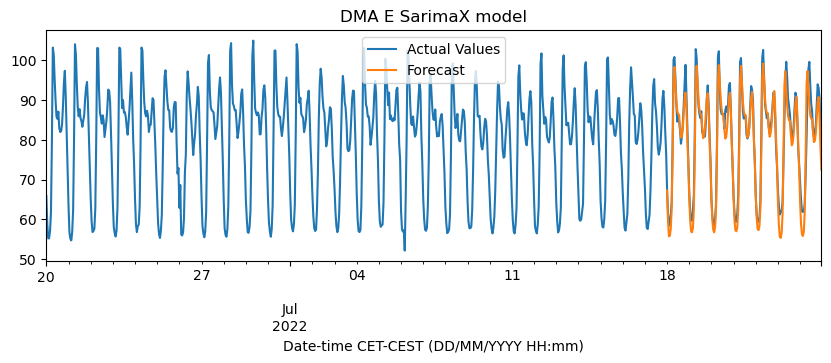

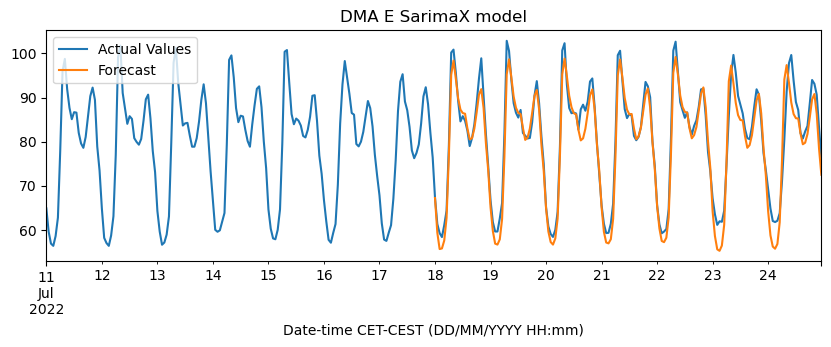

Performance indicators
DMA E SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.15            6.98             2.58           11.71 



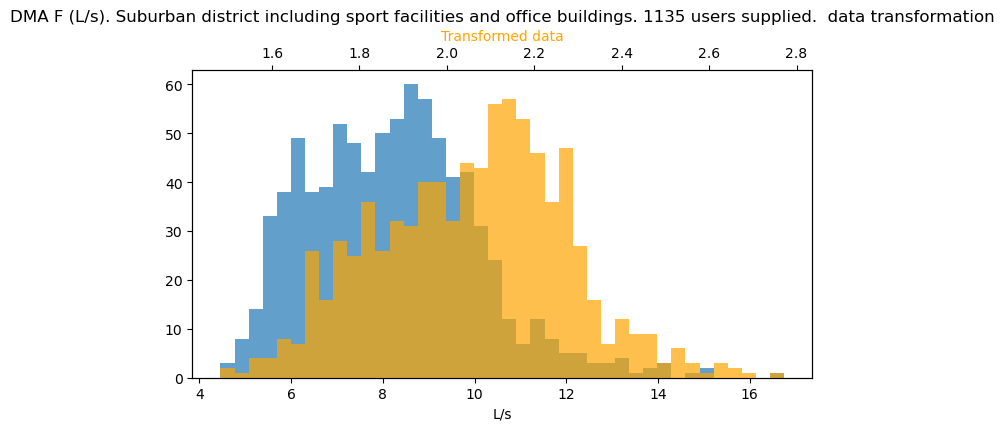

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.92797D-01    |proj g|=  2.23939D+00

At iterate    5    f= -5.50983D-01    |proj g|=  5.16941D-01

At iterate   10    f= -5.54654D-01    |proj g|=  1.82893D+00

At iterate   15    f= -5.63962D-01    |proj g|=  4.40356D-01

At iterate   20    f= -5.67706D-01    |proj g|=  1.95665D+00

At iterate   25    f= -5.69223D-01    |proj g|=  1.94292D-01

At iterate   30    f= -5.71782D-01    |proj g|=  5.75303D-01

At iterate   35    f= -5.75176D-01    |proj g|=  5.32681D-02

At iterate   40    f= -5.75809D-01    |proj g|=  1.71658D-01

At iterate   45    f= -5.81878D-01    |proj g|=  6.56998D-01

At iterate   50    f= -5.84089D-01    |proj g|=  1.00350D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

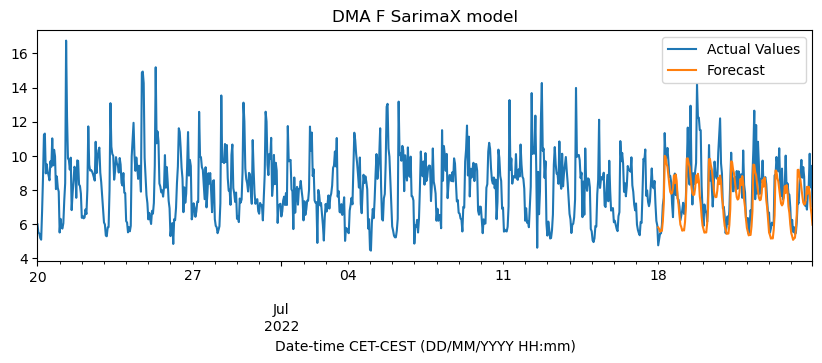

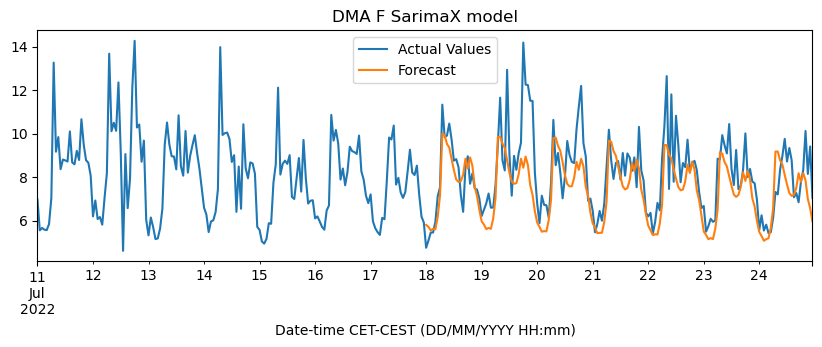

Performance indicators
DMA F SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.63            1.70             1.10           3.43 

Performance indicators


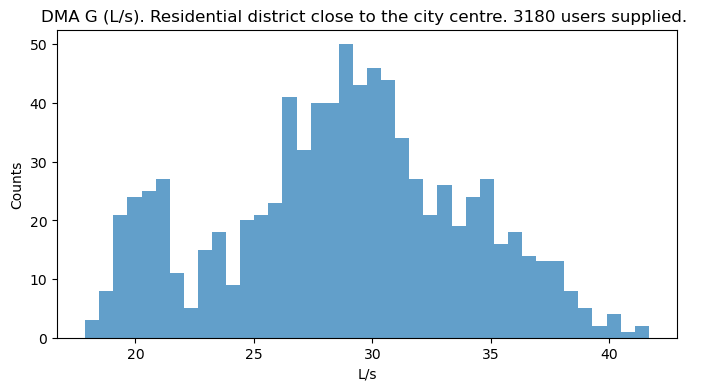

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70834D+00    |proj g|=  2.09640D-01


 This problem is unconstrained.



At iterate    5    f=  1.66640D+00    |proj g|=  2.71443D-01

At iterate   10    f=  1.62873D+00    |proj g|=  1.73071D-01

At iterate   15    f=  1.62578D+00    |proj g|=  3.31516D-02

At iterate   20    f=  1.62541D+00    |proj g|=  1.99371D-02

At iterate   25    f=  1.62504D+00    |proj g|=  1.18830D-02

At iterate   30    f=  1.62384D+00    |proj g|=  4.02134D-03

At iterate   35    f=  1.62377D+00    |proj g|=  2.78715D-03

At iterate   40    f=  1.62368D+00    |proj g|=  3.49118D-03

At iterate   45    f=  1.62354D+00    |proj g|=  9.44130D-03

At iterate   50    f=  1.62339D+00    |proj g|=  7.03745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

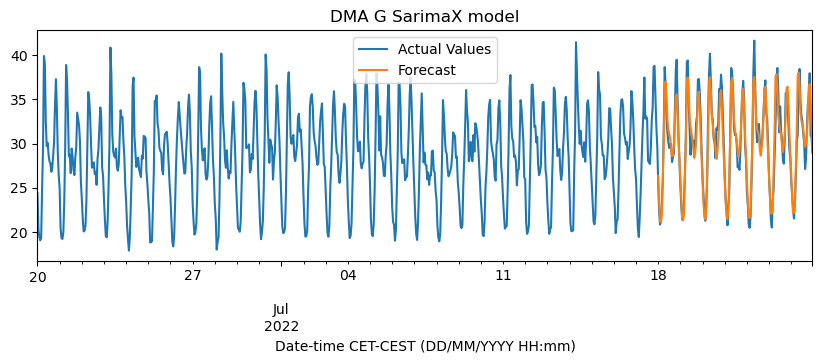

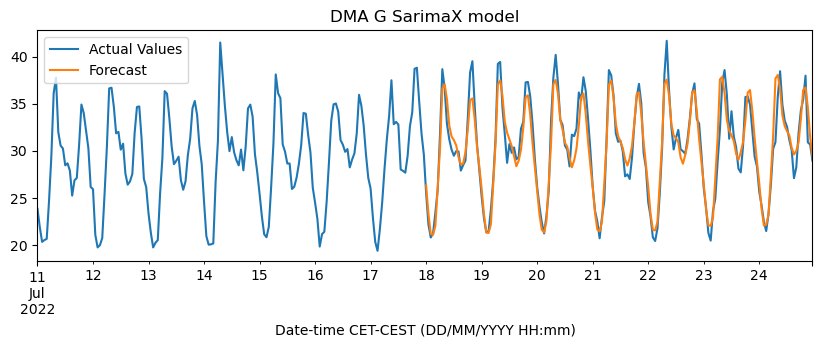

Performance indicators
DMA G SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.17            3.94             1.18           6.29 



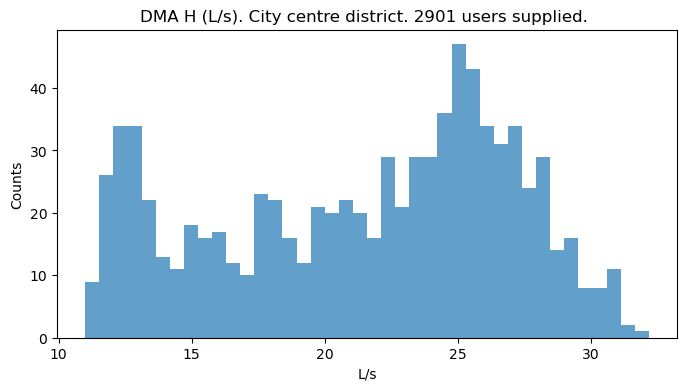

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61037D+00    |proj g|=  1.14599D-01


 This problem is unconstrained.



At iterate    5    f=  1.59017D+00    |proj g|=  7.74477D-02

At iterate   10    f=  1.54605D+00    |proj g|=  6.09255D-02

At iterate   15    f=  1.54255D+00    |proj g|=  7.33712D-02

At iterate   20    f=  1.53983D+00    |proj g|=  1.25971D-02

At iterate   25    f=  1.53835D+00    |proj g|=  1.64265D-02

At iterate   30    f=  1.53515D+00    |proj g|=  2.33497D-02

At iterate   35    f=  1.52898D+00    |proj g|=  7.57309D-02

At iterate   40    f=  1.52811D+00    |proj g|=  7.65727D-02

At iterate   45    f=  1.52634D+00    |proj g|=  4.01510D-02

At iterate   50    f=  1.52403D+00    |proj g|=  4.66370D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

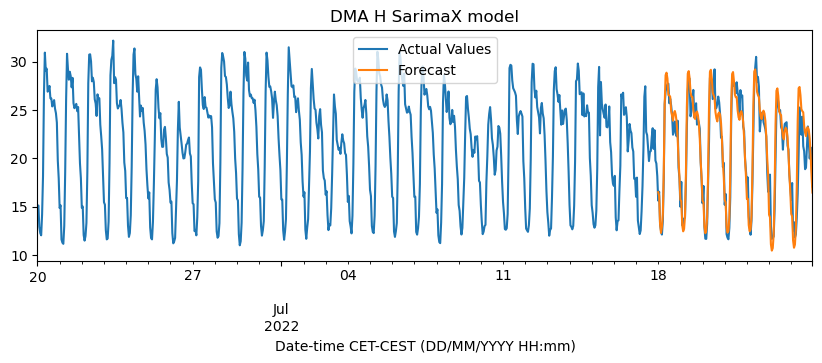

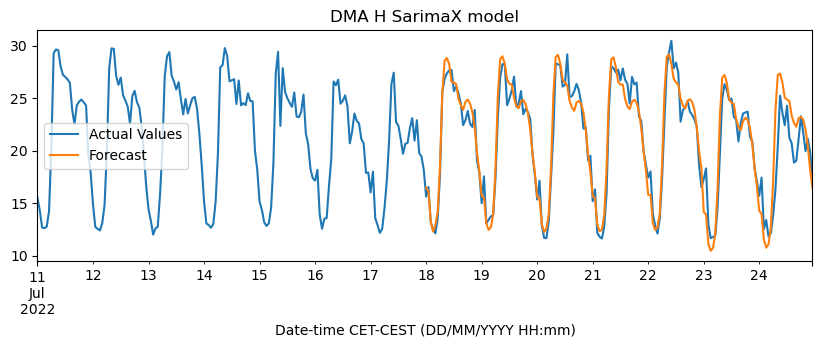

Performance indicators
DMA H SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.86            1.91             1.28           4.05 



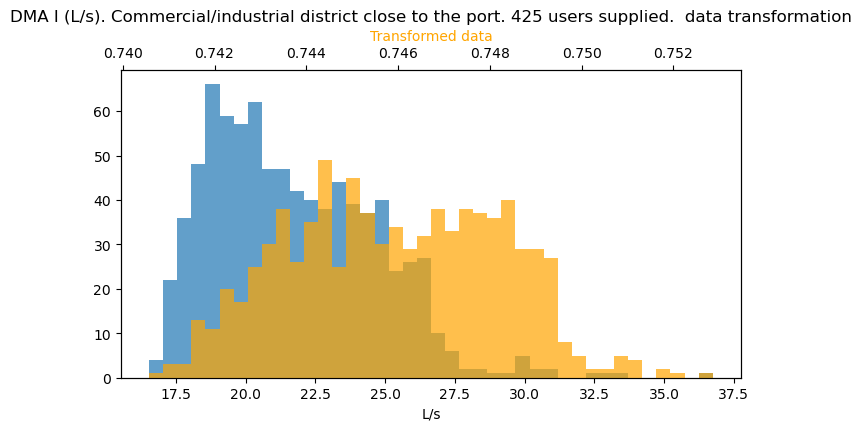

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.12656D+00    |proj g|=  2.34590D+02


 This problem is unconstrained.



At iterate    5    f= -5.16091D+00    |proj g|=  3.06294D+01
  ys=-3.255E-10  -gs= 6.758E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      7     57      2     1     0   3.027D+01  -5.161D+00
  F =  -5.1609094584942046     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


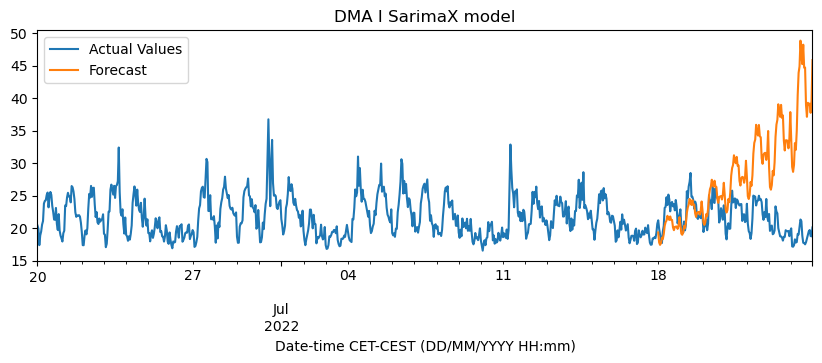

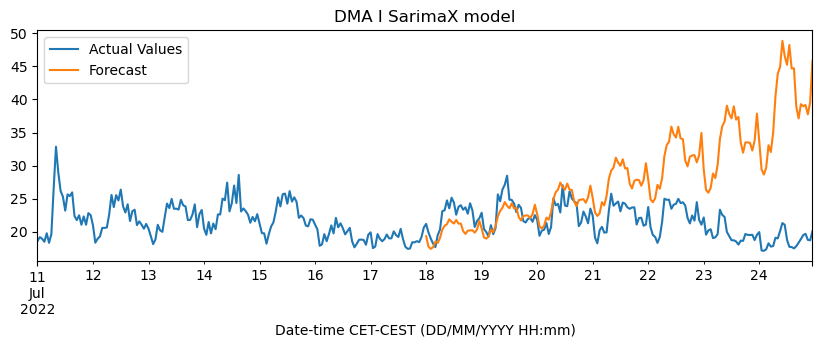

Performance indicators
DMA I SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.17            4.11             8.47           14.75 

Performance indicators


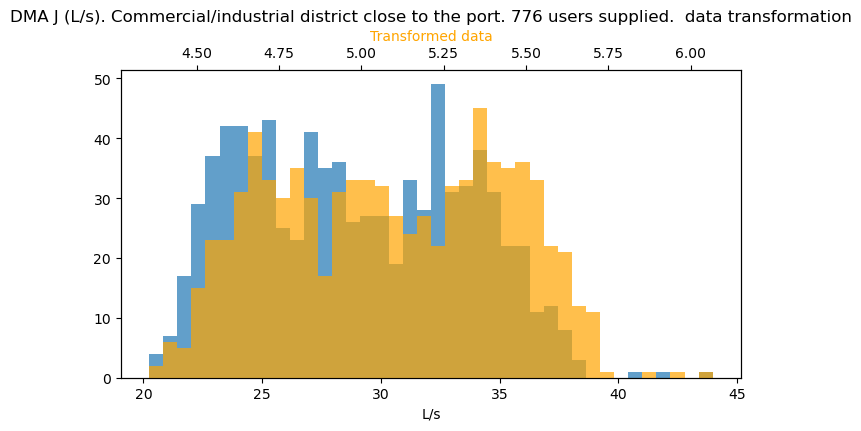

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92563D-01    |proj g|=  2.57653D+00


 This problem is unconstrained.



At iterate    5    f= -7.39653D-01    |proj g|=  5.77439D-01

At iterate   10    f= -7.42907D-01    |proj g|=  2.11023D+00

At iterate   15    f= -7.49675D-01    |proj g|=  6.10481D-01

At iterate   20    f= -7.55810D-01    |proj g|=  1.89433D-01

At iterate   25    f= -7.56596D-01    |proj g|=  2.67437D-01

At iterate   30    f= -7.59093D-01    |proj g|=  1.17649D-01

At iterate   35    f= -7.60880D-01    |proj g|=  9.43377D-01

At iterate   40    f= -7.67196D-01    |proj g|=  1.79326D-01

At iterate   45    f= -7.67560D-01    |proj g|=  8.51945D-02

At iterate   50    f= -7.68240D-01    |proj g|=  3.84350D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

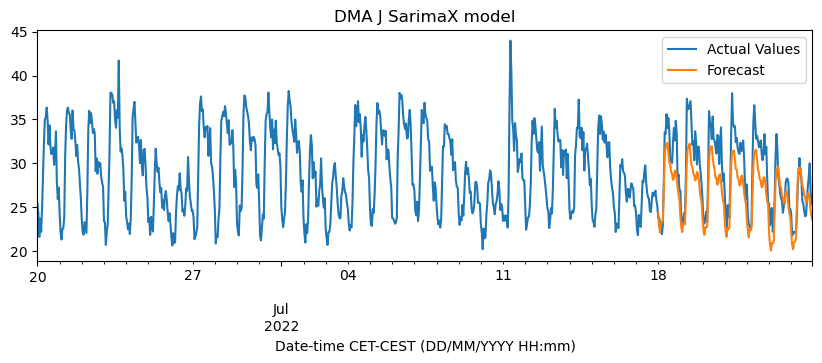

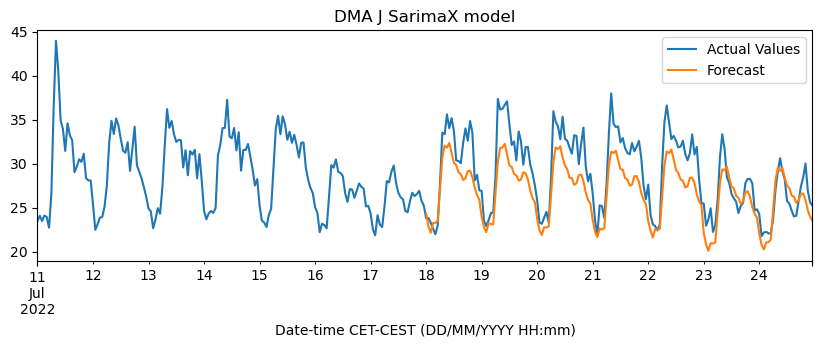

Performance indicators
DMA J SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.26            5.69             2.50           10.45 

Performance indicators


In [5]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

i = 0
# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    ## data transformation
    if dma not in ['DMA D (L/s)','DMA E (L/s)','DMA G (L/s)','DMA H (L/s)']:
        inflow_data_transformed, lmda = boxcox_transform(tseries_df,lmda=None,alpha=None,optimizer=None)

        # compare distributions of original and transformed data
        fig, ax = plt.subplots(figsize=(8,4))
        ax2 = ax.twiny()
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. " + " data transformation")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        ax2.hist(inflow_data_transformed.values, density=False,bins=40, color='orange', alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        ax2.set_xlabel("Transformed data", color='orange')
        plt.show()


        # demand time series
        y = inflow_data_transformed
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        y_train_original, y_test_original = temporal_train_test_split(tseries_df, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.

        model = SARIMAX(y_train, exog=X_train, order=(4,1,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        # make predictions
        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

        # recover prediction in original format
        y_pred_recovered = inv_boxcox_tranform(y_pred['mean'], lmda, out=None)
        y_pred_recovered_lower = inv_boxcox_tranform(y_pred['mean_ci_lower'], lmda, out=None)
        y_pred_recovered_upper = inv_boxcox_tranform(y_pred['mean_ci_upper'], lmda, out=None)

        # plot results
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred_recovered.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred_recovered.index, y_pred_recovered_lower, y_pred_recovered_upper,color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test_original, y_pred_recovered, dma[:5]+' SarimaX 4-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
        print('Performance indicators')
    else:
        # plot data distribution
        fig, ax = plt.subplots(figsize=(8,4))
        plt.title(dma + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
        ax.hist(tseries_df.values, density=False,bins=40,alpha=0.7)
        plt.ylabel('Counts')
        ax.set_xlabel("L/s")
        plt.show()
        
        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        model = SARIMAX(y_train, exog=X_train, order=(4,1,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        #ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        # plot forecast and last two weeks of time series
        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 4-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
    i = i+1

In [6]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 4-Weeks,1.570,6.889,0.897,9.356
DMA B SarimaX 4-Weeks,0.856,3.178,0.637,4.671
DMA C SarimaX 4-Weeks,0.635,1.860,1.158,3.652
DMA D SarimaX 4-Weeks,2.490,6.603,2.397,11.490
DMA E SarimaX 4-Weeks,2.147,6.984,2.582,11.712
DMA F SarimaX 4-Weeks,0.632,1.703,1.097,3.432
DMA G SarimaX 4-Weeks,1.171,3.939,1.180,6.290
DMA H SarimaX 4-Weeks,0.861,1.913,1.279,4.053
DMA I SarimaX 4-Weeks,2.171,4.110,8.471,14.753
DMA J SarimaX 4-Weeks,2.264,5.690,2.497,10.451


In [7]:
results_df['Total'].sum()

79.86000000000001